# **기본 셋팅**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install shap

In [4]:
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report
# import shap



from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score



from lightgbm import LGBMClassifier
from lightgbm import plot_importance


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

In [5]:
df = pd.read_csv('/content/drive/Shareddrives/데캡디/Result/Raw_data/x_plus_y_final.csv')
raw_data = df.copy()
raw_X = raw_data.drop('is_applied', axis = 1)
raw_Y = raw_data['is_applied']

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/데캡디/Result/sampling_data/Over_sampling_df.csv')
over_data = df.copy()
over_X = over_data.drop('is_applied', axis = 1)
over_Y = over_data['is_applied']

In [16]:
# Over_sampling random_state = 42, 20% test size
df = pd.read_csv('/content/drive/Shareddrives/데캡디/Result/sampling_data/Over_sampling_20.csv')
over_data = df.copy()
over_X = over_data.drop('is_applied', axis = 1)
over_Y = over_data['is_applied']

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/데캡디/Result/sampling_data/Under_sampling_df.csv')
under_data = df.copy()
under_X = under_data.drop('is_applied', axis = 1)
under_Y = under_data['is_applied']

In [9]:
X_train, raw_X_test, y_train, raw_y_test = train_test_split(raw_X, raw_Y, test_size=0.2, random_state=42 )

# **RF**

In [ ]:
# from sklearn.model_selection import KFold

# cv = KFold(n_splits=10)            # Desired number of Cross Validation folds  #n_splits값이 클수록 오래걸림
# accuracies = list()
# max_attributes = 20
# depth_range = range(1, max_attributes)

# # Testing max_depths from 1 to max attributes
# # Uncomment prints for details about each Cross Validation pass
# for depth in depth_range:
#     fold_accuracy = []
#     rand_clf = RandomForestClassifier(max_depth = depth)
#     # print("Current max depth: ", depth, "\n")
#     for train_fold, valid_fold in cv.split(X_train):
#         # f_train = X_train.loc[train_fold] # Extract train data with cv indices
#         # f_valid = X_train.loc[valid_fold] # Extract valid data with cv indices

#         model = rand_clf.fit(X_train, y_train)
#         valid_acc = model.score(X_test, y_test)
#         fold_accuracy.append(valid_acc)

#     avg = sum(fold_accuracy)/len(fold_accuracy)
#     accuracies.append(avg)
#     # print("Accuracy per fold: ", fold_accuracy, "\n")
#     # print("Average accuracy: ", avg)
#     # print("\n")
    
# # Just to show results conveniently
# df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
# df = df[["Max Depth", "Average Accuracy"]]
# print(df.to_string(index=False))

In [ ]:
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                        max_depth=None, max_features='auto', max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=100,
#                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
#                        warm_start=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(under_X, under_Y, test_size=0.2, random_state=42 )
print(X_test.shape)    

(7548, 77)


In [ ]:
def rand_clf_func(X, Y):
    start = time.time() 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42 )
    X_test = raw_X_test
    y_test = raw_y_test
    rand_clf = RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=42, max_depth=15)

    rand_clf.fit(X_train, y_train)
    y_pred = rand_clf.predict(X_test)

    params = {
        'max_depth' : [3, 15],
        'n_estimators' : [100, 500, 1000],
        'max_features' : [3, 5, 8]
    }

    grid_cv = GridSearchCV(rand_clf, param_grid=params, cv=3, verbose=1 , n_jobs=-1)
    grid_cv.fit(X_train, y_train)
    print('최적 하이퍼 파라미터 :\n', grid_cv.best_params_)
    print('최고 예측 정확도 : {0:.3f}'.format(grid_cv.best_score_))

    rf_pred = grid_cv.best_estimator_.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    print('최적 파라미터 적용 GBM 정확도 : {0:.3f}'.format(rf_accuracy))


    print('훈련세트 정확도: {:.3f}' .format(rand_clf.score(X_train, y_train)))
    print('테스트세트 정확도: {:.3f}' .format(rand_clf.score(X_test, y_test)))
    print(confusion_matrix(y_test, rf_pred))
    print(classification_report(y_test, rf_pred))

    feature_scores = pd.Series(grid_cv.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    top20 = feature_scores[:20]

    plt.figure(figsize=(8,6))
    plt.title('Top 20 Feature Importances')
    sns.barplot(x = top20, y=top20.index)
    plt.show()
    
    sec = time.time() - start
    times = str(datetime.timedelta(seconds = sec))
    short = times.split(".")[0]
    print(f"{short} sec")

    # shap.initjs()
    # explainer = shap.TreeExplainer(rand_clf)
    # shap_values = explainer.shap_values(X_test)
    # fig = shap.summary_plot(shap_values, X_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
최적 하이퍼 파라미터 :
 {'max_depth': 15, 'max_features': 8, 'n_estimators': 1000}
최고 예측 정확도 : 0.784
최적 파라미터 적용 GBM 정확도 : 0.789
훈련세트 정확도: 0.808
테스트세트 정확도: 0.789
[[5578  771]
 [1263 2045]]
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      6349
         1.0       0.73      0.62      0.67      3308

    accuracy                           0.79      9657
   macro avg       0.77      0.75      0.76      9657
weighted avg       0.78      0.79      0.78      9657



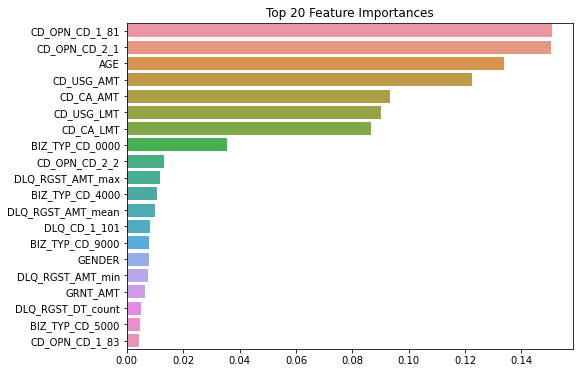

0:04:27 sec


In [ ]:
rand_clf_func(raw_X, raw_Y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
최적 하이퍼 파라미터 :
 {'max_depth': 15, 'max_features': 8, 'n_estimators': 1000}
최고 예측 정확도 : 0.734
최적 파라미터 적용 GBM 정확도 : 0.800
훈련세트 정확도: 0.761
테스트세트 정확도: 0.798
[[5550  799]
 [1136 2172]]
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      6349
         1.0       0.73      0.66      0.69      3308

    accuracy                           0.80      9657
   macro avg       0.78      0.77      0.77      9657
weighted avg       0.80      0.80      0.80      9657



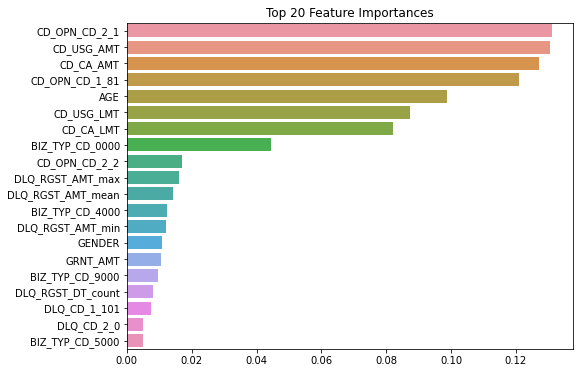

0:03:49 sec


In [ ]:
rand_clf_func(under_X, under_Y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
최적 하이퍼 파라미터 :
 {'max_depth': 15, 'max_features': 8, 'n_estimators': 500}
최고 예측 정확도 : 0.779
최적 파라미터 적용 GBM 정확도 : 0.791
훈련세트 정확도: 0.794
테스트세트 정확도: 0.791
[[5201 1148]
 [ 868 2440]]
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      6349
         1.0       0.68      0.74      0.71      3308

    accuracy                           0.79      9657
   macro avg       0.77      0.78      0.77      9657
weighted avg       0.80      0.79      0.79      9657



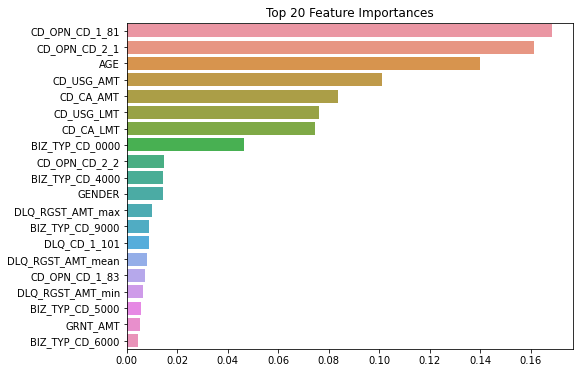

0:05:25 sec


In [ ]:
rand_clf_func(over_X, over_Y)

# **GBM**

In [ ]:
def gbm_clf_func(X, Y):
    start = time.time() 

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42 )
    X_test = raw_X_test
    y_test = raw_y_test
    
    gbm_clf = GradientBoostingClassifier(random_state = 42)
    gbm_clf.fit(X_train, y_train)

    gbm_pred = gbm_clf.predict(X_test)
    gbm_accuracy = accuracy_score(y_test, gbm_pred)
    print('GBM 정확도 : {0:.3f}'.format(gbm_accuracy))

    params = {
        'max_depth' : [3, 7, 15],
        'n_estimators' : [100, 500, 1000],
        'learning_rate' : [0.05, 0.1]
    }

    gridcv = GridSearchCV(gbm_clf, param_grid=params, cv=3, verbose=1 , n_jobs=-1)
    gridcv.fit(X_train, y_train)
    print('최적 하이퍼 파라미터 :\n', gridcv.best_params_)
    print('최고 예측 정확도 : {0:.3f}'.format(gridcv.best_score_))



    gbm_pred = gridcv.best_estimator_.predict(X_test)
    gbm_accuracy = accuracy_score(y_test, gbm_pred)
    print('최적 파라미터 적용 GBM 정확도 : {0:.3f}'.format(gbm_accuracy))

    # params = {'max_depth':[3, 5, 7, 15], 
    #           'min_child_weight':[1,3], 
    #           'colsample_bytree':[0.5, 0.75]}
    # gridcv = GridSearchCV(gbm_clf, param_grid=params, cv=3)
    # gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)


    # gbm_clf = GradientBoostingClassifier(n_estimators = 1000, 
    #                         random_state = 42, 
    #                         colsample_bytree = gridcv.best_params_['colsample_bytree'], 
    #                         max_depth = gridcv.best_params_['max_depth'], 
    #                         min_child_weight = gridcv.best_params_['min_child_weight']
    #                         )
    # gbm_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    # gbm_roc_score = roc_auc_score(y_test, gbm_clf.predict_proba(X_test)[:,1], average='macro')

    # print('튜닝된 파라미터: ', gridcv.best_params_)
    # print('튜닝된 파라미터 모델 AUC: ', gbm_roc_score)


    print('훈련세트 정확도: {:.3f}' .format(gridcv.score(X_train, y_train)))
    print('테스트세트 정확도: {:.3f}' .format(gridcv.score(X_test, y_test)))

    print(confusion_matrix(y_test, gbm_clf.predict(X_test)))
    print(classification_report(y_test, gbm_clf.predict(X_test)))

    feature_scores = pd.Series(gridcv.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    top20 = feature_scores[:20]

    plt.figure(figsize=(8,6))
    plt.title('Top 20 Feature Importances')
    sns.barplot(x=top20, y=top20.index)
    plt.show()

    sec = time.time() - start
    times = str(datetime.timedelta(seconds = sec))
    short = times.split(".")[0]
    print(f"{short} sec")

GBM 정확도 : 0.791
Fitting 3 folds for each of 18 candidates, totalling 54 fits
최적 하이퍼 파라미터 :
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
최고 예측 정확도 : 0.785
최적 파라미터 적용 GBM 정확도 : 0.791
훈련세트 정확도: 0.790
테스트세트 정확도: 0.791
[[5626  723]
 [1300 2008]]
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      6349
         1.0       0.74      0.61      0.67      3308

    accuracy                           0.79      9657
   macro avg       0.77      0.75      0.76      9657
weighted avg       0.79      0.79      0.79      9657



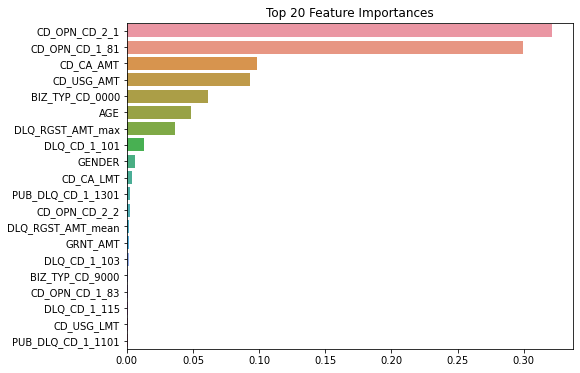

0:33:02 sec


In [ ]:
gbm_clf_func(raw_X, raw_Y)

GBM 정확도 : 0.785
Fitting 3 folds for each of 18 candidates, totalling 54 fits
최적 하이퍼 파라미터 :
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
최고 예측 정확도 : 0.736
최적 파라미터 적용 GBM 정확도 : 0.784
훈련세트 정확도: 0.747
테스트세트 정확도: 0.784
[[5513  836]
 [1242 2066]]
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      6349
         1.0       0.71      0.62      0.67      3308

    accuracy                           0.78      9657
   macro avg       0.76      0.75      0.75      9657
weighted avg       0.78      0.78      0.78      9657



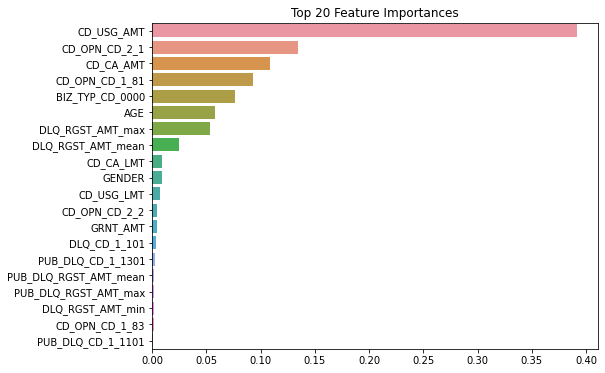

0:28:25 sec


In [ ]:
gbm_clf_func(under_X, under_Y)

GBM 정확도 : 0.777
Fitting 3 folds for each of 18 candidates, totalling 54 fits
최적 하이퍼 파라미터 :
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
최고 예측 정확도 : 0.780
최적 파라미터 적용 GBM 정확도 : 0.796
훈련세트 정확도: 0.802
테스트세트 정확도: 0.796
[[5123 1226]
 [ 927 2381]]
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      6349
         1.0       0.66      0.72      0.69      3308

    accuracy                           0.78      9657
   macro avg       0.75      0.76      0.76      9657
weighted avg       0.78      0.78      0.78      9657



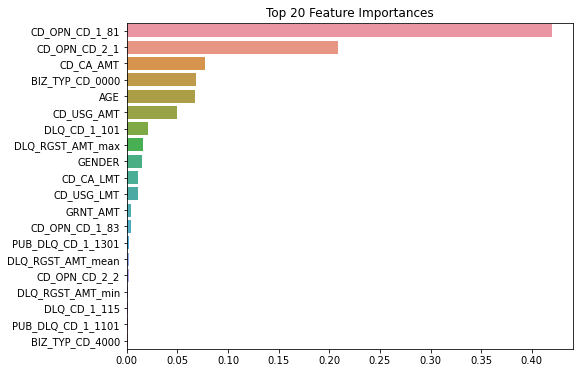

0:47:41 sec


In [ ]:
gbm_clf_func(over_X, over_Y)

# **XGBoost**

In [10]:
def xgb_clf_func(X, Y):

    start = time.time() 

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_test = raw_X_test
    y_test = raw_y_test

    xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
    params = {'max_depth':[5,7], 
              'min_child_weight':[1,3], 
              'colsample_bytree':[0.5, 0.75]}
    gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
    gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)


    xgb_clf = XGBClassifier(n_estimators = 1000, 
                            random_state = 42, 
                            colsample_bytree = gridcv.best_params_['colsample_bytree'], 
                            max_depth = gridcv.best_params_['max_depth'], 
                            min_child_weight = gridcv.best_params_['min_child_weight']
                            )
    xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')

    print('튜닝된 파라미터: ', gridcv.best_params_)
    print('튜닝된 파라미터 모델 AUC: ', xgb_roc_score)

    print('훈련세트 정확도: {:.3f}' .format(xgb_clf.score(X_train, y_train)))
    print('테스트세트 정확도: {:.3f}' .format(xgb_clf.score(X_test, y_test)))

    print(confusion_matrix(y_test, xgb_clf.predict(X_test)))
    print(classification_report(y_test, xgb_clf.predict(X_test)))

    feature_scores = pd.Series(xgb_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    top20 = feature_scores[:20]

    plt.figure(figsize=(8,6))
    plt.title('Top 20 Feature Importances')
    sns.barplot(x=top20, y=top20.index)
    plt.show()

    sec = time.time() - start
    times = str(datetime.timedelta(seconds = sec))
    short = times.split(".")[0]
    print(f"{short} sec")

튜닝된 파라미터:  {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 3}
튜닝된 파라미터 모델 AUC:  0.8569722583396294
훈련세트 정확도: 0.799
테스트세트 정확도: 0.789
[[5645  704]
 [1333 1975]]
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      6349
         1.0       0.74      0.60      0.66      3308

    accuracy                           0.79      9657
   macro avg       0.77      0.74      0.75      9657
weighted avg       0.78      0.79      0.78      9657



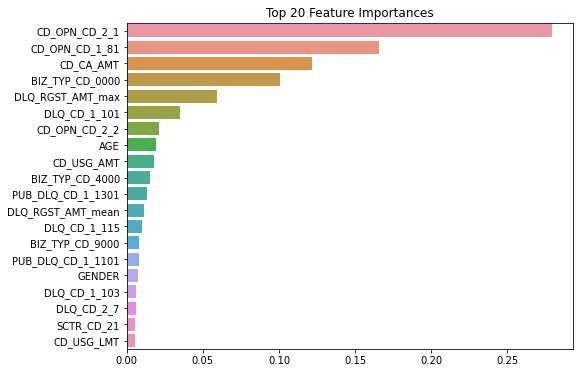

0:03:51 sec


In [18]:
xgb_clf_func(raw_X, raw_Y)

튜닝된 파라미터:  {'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 1}
튜닝된 파라미터 모델 AUC:  0.8960057930268466
훈련세트 정확도: 0.851
테스트세트 정확도: 0.850
[[5871  478]
 [ 970 2338]]
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89      6349
         1.0       0.83      0.71      0.76      3308

    accuracy                           0.85      9657
   macro avg       0.84      0.82      0.83      9657
weighted avg       0.85      0.85      0.85      9657



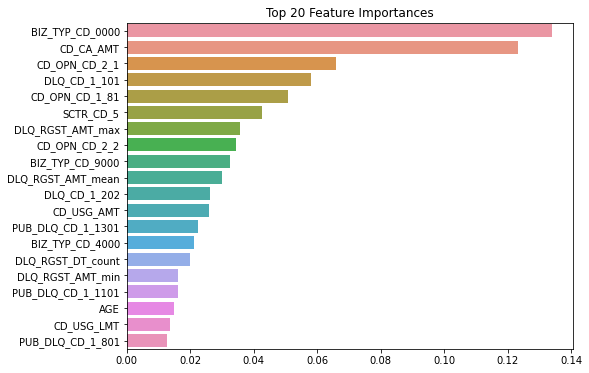

0:03:13 sec


In [ ]:
xgb_clf_func(under_X, under_Y)

튜닝된 파라미터:  {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_weight': 3}
튜닝된 파라미터 모델 AUC:  0.8559643779414366
훈련세트 정확도: 0.781
테스트세트 정확도: 0.768
[[4944 1405]
 [ 834 2474]]
              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82      6349
         1.0       0.64      0.75      0.69      3308

    accuracy                           0.77      9657
   macro avg       0.75      0.76      0.75      9657
weighted avg       0.78      0.77      0.77      9657



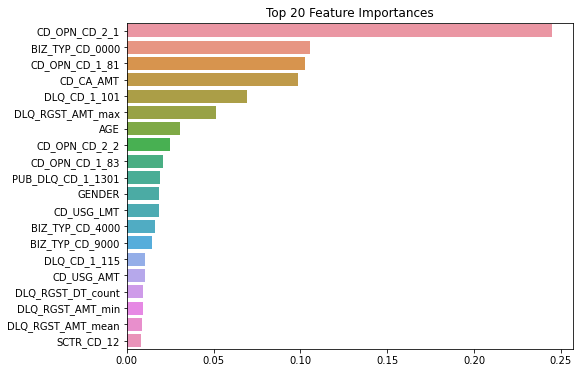

0:03:11 sec


In [17]:
xgb_clf_func(over_X, over_Y)

# **LightGBM**

In [ ]:
def lgbm_clf_func(X, Y):

    start = time.time() 

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42 )
    X_test = raw_X_test
    y_test = raw_y_test

    lgbm_clf = LGBMClassifier(n_estimators=400)
    evals = [(X_test, y_test)]
    lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=False)
    y_pred = lgbm_clf.predict(X_test)
    # pred_proba = lgbm_clf.predict_proba(X_test)[:,1]

    accuracy = accuracy_score(y_test, y_pred)

    params = {'max_depth':[5,7], 
              'min_child_weight':[1,3], 
              'colsample_bytree':[0.5, 0.75]}
    gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
    gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)

    lgbm_clf = LGBMClassifier(n_estimators = 1000, 
                            random_state = 42, 
                            colsample_bytree = gridcv.best_params_['colsample_bytree'], 
                            max_depth = gridcv.best_params_['max_depth'], 
                            min_child_weight = gridcv.best_params_['min_child_weight']
                            )
    lgbm_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')

    print('튜닝된 파라미터: ', gridcv.best_params_)
    print('튜닝된 파라미터 모델 AUC: ', lgbm_roc_score)


    feature_scores = pd.Series(lgbm_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    top20 = feature_scores[:20]

    print('모델 정확도: {:.3f}'.format(accuracy))
    print('훈련세트 정확도: {:.3f}' .format(lgbm_clf.score(X_train, y_train)))
    print('테스트세트 정확도: {:.3f}' .format(lgbm_clf.score(X_test, y_test)))

    print(confusion_matrix(y_test, lgbm_clf.predict(X_test)))
    print(classification_report(y_test, lgbm_clf.predict(X_test)))


    plt.figure(figsize=(8,6))
    plt.title('Top 20 Feature Importances')
    sns.barplot(x=top20, y=top20.index)
    plt.show()


    sec = time.time() - start
    times = str(datetime.timedelta(seconds = sec))
    short = times.split(".")[0]
    print(f"{short} sec")

    # fig, ax = plt.subplots(figsize=(10,12))
    # plot_importance(lgbm_wrapper, ax=ax)
    # plt.show()

튜닝된 파라미터:  {'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 1}
튜닝된 파라미터 모델 AUC:  0.8564539627011881
모델 정확도: 0.788
훈련세트 정확도: 0.798
테스트세트 정확도: 0.788
[[5613  736]
 [1313 1995]]
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.85      6349
         1.0       0.73      0.60      0.66      3308

    accuracy                           0.79      9657
   macro avg       0.77      0.74      0.75      9657
weighted avg       0.78      0.79      0.78      9657



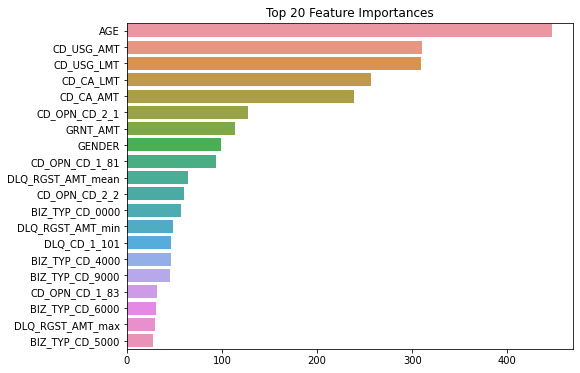

0:00:39 sec


In [ ]:
lgbm_clf_func(raw_X, raw_Y)

튜닝된 파라미터:  {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_weight': 1}
튜닝된 파라미터 모델 AUC:  0.8745112722814036
모델 정확도: 0.825
훈련세트 정확도: 0.800
테스트세트 정확도: 0.817
[[5706  643]
 [1121 2187]]
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      6349
         1.0       0.77      0.66      0.71      3308

    accuracy                           0.82      9657
   macro avg       0.80      0.78      0.79      9657
weighted avg       0.81      0.82      0.81      9657



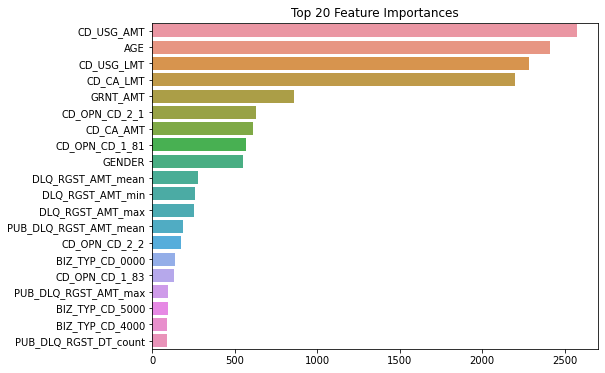

0:00:49 sec


In [ ]:
lgbm_clf_func(under_X, under_Y)

튜닝된 파라미터:  {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 1}
튜닝된 파라미터 모델 AUC:  0.8903501308320937
모델 정확도: 0.820
훈련세트 정확도: 0.828
테스트세트 정확도: 0.821
[[5549  800]
 [ 929 2379]]
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      6349
         1.0       0.75      0.72      0.73      3308

    accuracy                           0.82      9657
   macro avg       0.80      0.80      0.80      9657
weighted avg       0.82      0.82      0.82      9657



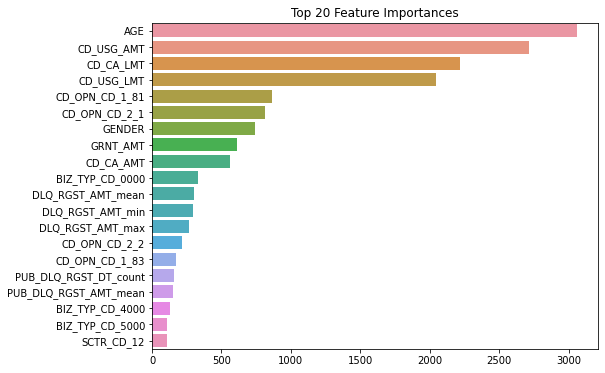

0:02:38 sec


In [ ]:
lgbm_clf_func(over_X, over_Y)